In [2]:
import os
os.chdir('/Users/sukhmac/Programming/FunCoding/Research/RLProgramming/GittenBandit')  # Set the correct path to your project root

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Environment.mab_environment import Mab
from Environment.test_cases import test1
from Strategies.strategy_interface import StrategyInterface

In [4]:
class QLearning(StrategyInterface):
    def __init__(self, 
                 num_arms,
                 num_states_per_arm, 
                 init_learning_rate, 
                 discount_factor, 
                 temperature_mode):
        super().__init__("QLearning")
        self.k = num_arms  # Number of arms (tasks)
        self.n = num_states_per_arm  # Number of states per task
        self.discount_factor = discount_factor
        
        # Initialize the Q-table: (cur_state, action, restart_state, task)
        self.q_table = np.zeros((self.n, 2, self.n, self.k))  # Actions: 0 = Continue (C), 1 = Restart (R)
        self.num_updates_q_table = np.zeros((self.n, 2, self.n, self.k))  # stores how many updates for each q value have been performed
     
        self.init_learning_rate = init_learning_rate  # adaptive learning rate based on Barto et al 1991 (Appendix B)
        self.cur_learning_rate = np.full((self.n, 2, self.n, self.k), self.init_learning_rate)  # lr for each q value in the Q table
        self.tau = 300  # used in updating cur_learning_rate
        
        self.temperature_mode = temperature_mode
        if temperature_mode == "Boltzmann":
            self.max_temp = 200  # Boltzmann temperature
            self.min_temp = 0.5  # based on Barto et al 1991 (Appendix B)
            self.cur_temp = self.max_temp
            self.beta = 0.992  # used to update cur_temp
        elif temperature_mode == "epsilon-greedy-gittin":
            self.epsilon_greedy = 0.1  # probability of picking action at random

    def get_action(self, cur_state):
        if self.temperature_mode == "Boltzmann":
            # Calculate the Boltzmann distribution for action selection based on current estimate of gittins index
            action_probabilities = np.zeros(self.k)
            total = 0
            for i in range(self.k):
                total += np.exp(self.q_table[cur_state[i], 0, cur_state[i], i] / self.cur_temp)
            for i in range(self.k):
                action_probabilities[i] = np.exp(self.q_table[cur_state[i], 0, cur_state[i], i] / self.cur_temp) / total
                
        elif self.temperature_mode == "epsilon-greedy-gittin":
            # With 1-epsilon probability pick the arm with the state that has highest gitten value
            # ,And with prob epsilon pick randomly
            cur_gittens = np.array([self.q_table[cur_state[i], 0, cur_state[i], i] for i in range(self.k)])
            best_gittens = np.argmax(cur_gittens)
            action_probabilities = np.full(self.k, self.epsilon_greedy / self.k)
            action_probabilities[best_gittens] += (1-self.epsilon_greedy)
            
        # Select action based on the probabilities
        action = int(np.random.choice(range(self.k), p=action_probabilities))  # type: ignore
        
        return action, action_probabilities

    def update(self, prev_state_of_selected_arm, cur_action, reward, cur_state_of_selected_arm):
        i = prev_state_of_selected_arm
        a = cur_action  # arm selected
        r = reward
        j = cur_state_of_selected_arm  # after transition state

        # sorry for the overload of k, here it means any state reached after taking action from i, to i from k.
        # don't confuse with self.k == num_arms, i-j-k seems more natural notation
        
        # update Q table
        for k in range(self.n):
            # Update for Continue (C)
            current_q_value = self.q_table[i, 0, k, a]
            max_next_q_value = max(self.q_table[j, 0, k, a], self.q_table[j, 1, k, a])
            new_q_value = (1 - self.cur_learning_rate[i, 0, k, a]) * current_q_value + \
                            self.cur_learning_rate[i, 0, k, a] * (r + self.discount_factor * max_next_q_value)
            self.q_table[i, 0, k, a] = new_q_value

            # Update for Restart (R)
            current_q_value_restart = self.q_table[k, 1, i, a]
            max_next_q_value_restart = max(self.q_table[j, 0, i, a], self.q_table[j, 1, i, a])
            new_q_value_restart = (1-self.cur_learning_rate[k, 1, i, a]) * current_q_value_restart + \
                                    self.cur_learning_rate[k, 1, i, a] * (r + self.discount_factor * max_next_q_value_restart)
            self.q_table[k, 1, i, a] = new_q_value_restart

        # update num_updates_q_table
        for k in range(self.n):
            self.num_updates_q_table[i, 0, k, a] += 1
            self.num_updates_q_table[k, 1, i, a] += 1

        # update learning rate
        for k in range(self.n):
            self.cur_learning_rate[i, 0, k, a] = (self.init_learning_rate * self.tau) / (self.tau + self.num_updates_q_table[i, 0, k, a]) 
            self.cur_learning_rate[k, 1, i, a] = (self.init_learning_rate * self.tau) / (self.tau + self.num_updates_q_table[k, 1, i, a]) 

        # decrease the temperature
        if self.temperature_mode == "Boltzmann":
            self.cur_temp = self.min_temp + self.beta * (self.cur_temp - self.min_temp)

    def reset(self): 
        self.q_table = np.zeros((self.n, 2, self.n, self.k))
        self.cur_learning_rate = np.full((self.n, 2, self.n, self.k), self.init_learning_rate)
        self.num_updates_q_table = np.zeros((self.n, 2, self.n, self.k))
        if self.temperature_mode == "Boltzmann":
            self.cur_temp = self.max_temp

In [5]:
def qlearning_visualize(gittin_history, save_path):
    num_runs, time_steps, num_arms, num_states_per_arm = gittin_history.shape
    
    for k in range(num_arms):
        for n in range(num_states_per_arm):
            values = np.mean(gittin_history[:, :, k, n], axis=0)
            plt.plot(values, label=f'({k},{n})')
            
            # Add index (k, n) as a text label above the line at the last time step
            plt.text(time_steps - 1, values[-1], f'({k},{n})', 
                     fontsize=8, verticalalignment='bottom', horizontalalignment='left')
    
    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Gittins Index')
    plt.title('Trajectory of Gittins index for Each (kth arm, nth state) state Over Time')
    
    # Show legend
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small', title='(k,n) Pairs')
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    # Save fig
    plt.savefig(save_path)

    # Display the plot
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 138.83 #Run/s]


Training Finished!


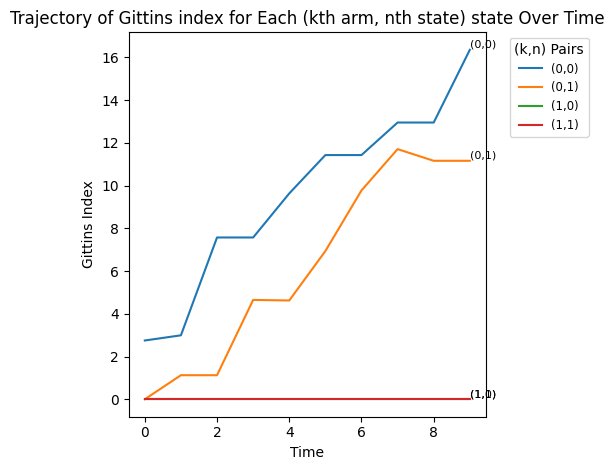

Plot saved


In [6]:
num_epochs = 10
num_runs = 2
test = test1
test_string = "test1"

mab = Mab(num_arms = test.num_arms,
          num_states_per_arm = test.num_states_per_arm,
          transition_matrices = test.transition_matrices,
          reward_matrices = test.reward_matrices,
          initial_start_state = test.initial_start_state,
          homogeneous = test.homogeneous)

qlearning = QLearning(num_arms = test.num_arms, 
                      num_states_per_arm = test.num_states_per_arm,
                      init_learning_rate = 0.5,
                      discount_factor = test.discount_factor, 
                      temperature_mode = "epsilon-greedy-gittin")

gittin_history = np.zeros((num_runs, num_epochs, test.num_arms, test.num_states_per_arm))

for num_run in tqdm(range(num_runs), unit=" #Run"):
    mab.reset(random=True)
    qlearning.reset()
    
    for epoch in range(num_epochs):
        cur_state = mab.get_cur_state()
        cur_action, _ = qlearning.get_action(cur_state)
        next_state, cur_reward = mab.step(cur_action)
        qlearning.update(cur_state[cur_action], cur_action, cur_reward, next_state)

        # Store gittins
        for k in range(test.num_arms):
            for n in range(test.num_states_per_arm):
                gittin_history[num_run, epoch, k, n] = qlearning.q_table[n, 0, n, k]

print("Training Finished!")
save_path = f'Results/QLearning/{test_string}_gittin_plot_num_runs={num_runs}_time_steps={num_epochs}.png'
qlearning_visualize(gittin_history, save_path)
print("Plot saved")